In [585]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [986]:
import crop_sim
import importlib
importlib.reload(crop_sim)

<module 'crop_sim' from '/Users/theron/code/crop-models/crop_sim.py'>

In [987]:
zip_codes = crop_sim.load_zip("60601")
print(zip_codes)

     ZIP  latitude  longitude
0  60601   41.8858   -87.6181


In [988]:
# crop_sim.generate_near()

In [989]:
loca_tasmin, loca_tasmax = crop_sim.load_temperature_data(zip_codes)

In [990]:
ecocrop_df = crop_sim.load_ecocrop()

In [991]:


# Select your crop of interest (replace 'Maize' with your desired crop)
crop_name = 'Allium cepa' #onion
# crop_name= "Lycopersicon esculentum" # Tomatoes
# crop_name = "Brassica juncea" # Mustard greens
# crop_name = "Vigna unguiculata"
# crop_name = "Ipomoea batatas" # sweet potato
# crop_name = "Solanum tuberosum" # Potato
bolting = False
frost_tolerance = 0

tmin, tmax, topt_min, topt_max, gmin, gmax = crop_sim.load_crop_variables(ecocrop_df, crop_name)


In [992]:
zip_codes = crop_sim.add_loca_index(zip_codes, loca_tasmin, loca_tasmax)

In [993]:
print(zip_codes['loca_index'].values)

[(30, 22)]


In [994]:
lat, lon = zip_codes['loca_index'].values[0]

In [995]:
loca_tasmin_smoothed, loca_tasmax_smoothed = crop_sim.smooth_tas(loca_tasmin, loca_tasmax)

In [996]:
daily_suitability = crop_sim.suitability(bolting, loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, frost_tolerance)

In [997]:
# print(daily_suitability.isel(lat=lat, lon=lon))

In [998]:
growing_season_suitability = crop_sim.calculate_season_suitability(gmin, gmax, daily_suitability)
optimal_planting_ranges = crop_sim.calculate_optimal_planting_ranges(growing_season_suitability, lat, lon)


In [999]:
view_window = 105
print(optimal_planting_ranges)

{85: [[Timestamp('2022-05-08 12:00:00'), Timestamp('2022-07-21 12:00:00')], [Timestamp('2022-11-29 12:00:00'), Timestamp('2022-12-19 12:00:00')]], 95: [[Timestamp('2022-05-08 12:00:00'), Timestamp('2022-07-11 12:00:00')], [Timestamp('2022-11-29 12:00:00'), Timestamp('2022-12-09 12:00:00')]], 105: [[Timestamp('2022-05-08 12:00:00'), Timestamp('2022-07-01 12:00:00')], [Timestamp('2022-11-29 12:00:00'), Timestamp('2022-11-29 12:00:00')]], 115: [[Timestamp('2022-05-08 12:00:00'), Timestamp('2022-06-21 12:00:00')]], 125: [[Timestamp('2022-05-08 12:00:00'), Timestamp('2022-06-11 12:00:00')]], 135: [], 145: [], 155: [], 165: [], 175: []}


In [1000]:
matplotlib.pyplot.close()

In [1001]:
print(crop_sim.merge_overlapping_monthday_ranges(optimal_planting_ranges[view_window]))

[(5, 8, 7, 1), (11, 29, 11, 29)]


In [1002]:
%matplotlib widget

In [1003]:
import matplotlib

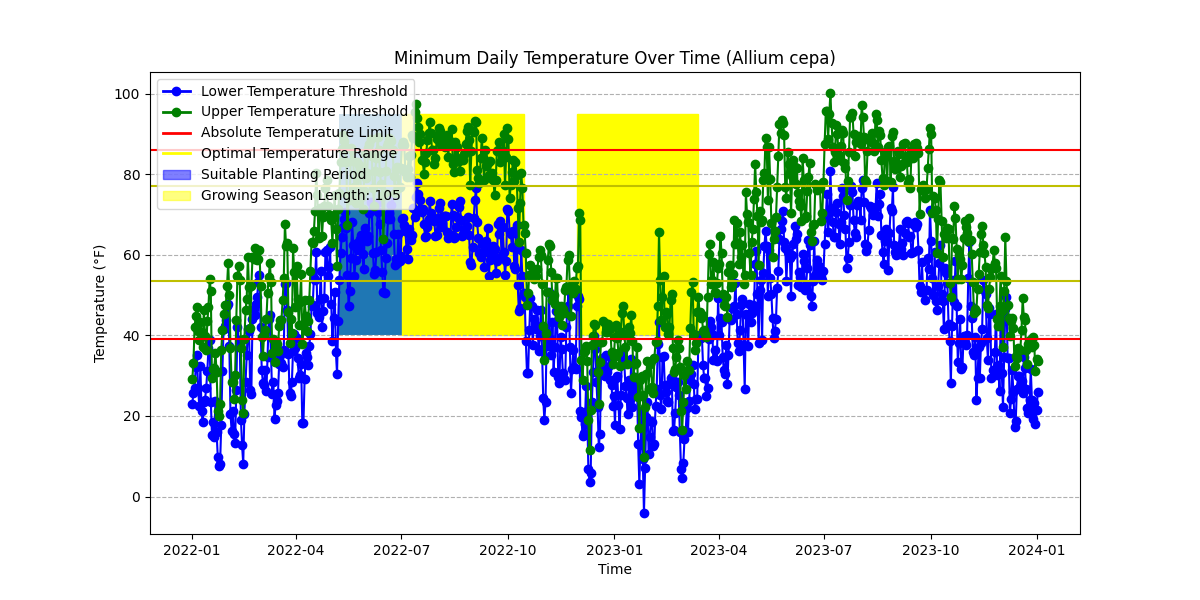

In [1004]:

crop_sim.plot_planting(loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, view_window, optimal_planting_ranges, lat, lon, crop_name)


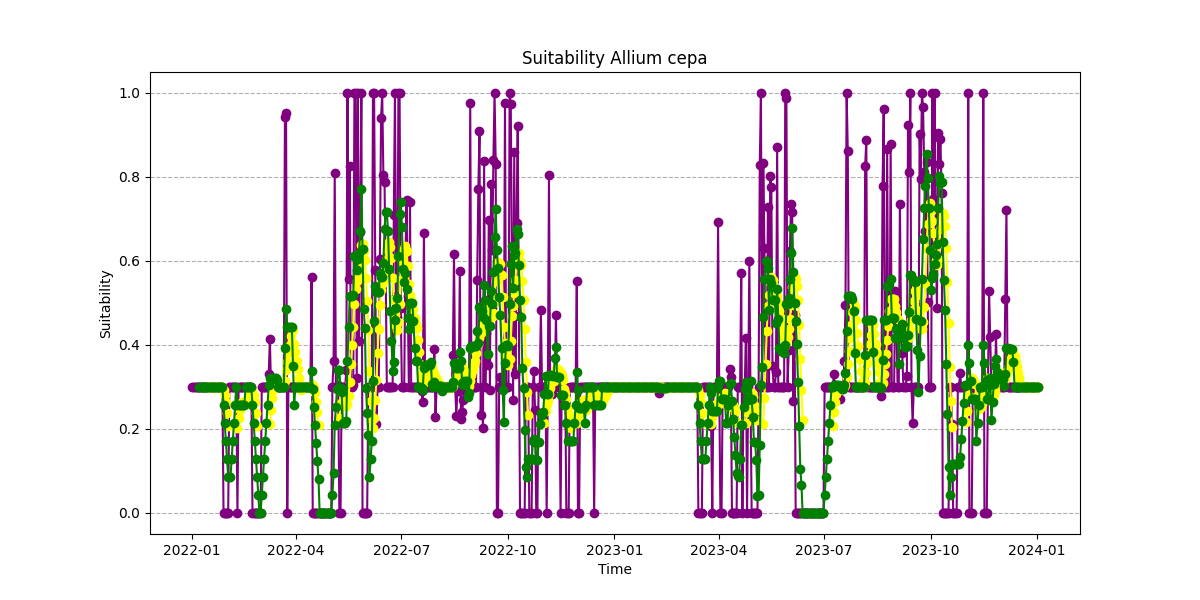

In [1005]:
crop_sim.plot_suitability(view_window, growing_season_suitability, daily_suitability, lat, lon, crop_name)